In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
spark = SparkSession.builder \
    .appName("StockPrediction") \
    .getOrCreate()


## Read CSV file for selected company

In [ ]:
# Read CSV into Spark DataFrame
df = spark.read.format("csv").option("header", "true").load("/FileStore/tables/MSFT1.csv")


### Feature Engineering

In [ ]:
# Select relevant columns and convert 'Date' column to date type
df = df.select('Date', 'Close').withColumn('Date', to_date(col('Date')))

# Define window size
n = 3

df = df.withColumn("Close", col("Close").cast("double"))

# Create a list of feature columns
feature_cols = [f'Close_lag_{i}' for i in range(n, 0, -1)]

# Add lagged features to DataFrame
for i in range(n, 0, -1):
    df = df.withColumn(f'Close_lag_{i}', lag('Close', i).over(Window.orderBy('Date')))

# Drop rows with null values resulting from lag
df = df.na.drop()

In [ ]:
df.printSchema()
df.show()

# Summary statistics
df.describe().show()

# Perform SQL queries
df.createOrReplaceTempView("stock_data")

root
 |-- Date: date (nullable = true)
 |-- Close: double (nullable = true)
 |-- Close_lag_3: double (nullable = true)
 |-- Close_lag_2: double (nullable = true)
 |-- Close_lag_1: double (nullable = true)

+----------+--------+-----------+-----------+-----------+
|      Date|   Close|Close_lag_3|Close_lag_2|Close_lag_1|
+----------+--------+-----------+-----------+-----------+
|1986-03-18|0.099826|   0.097222|   0.100694|   0.102431|
|1986-03-19| 0.09809|   0.100694|   0.102431|   0.099826|
|1986-03-20|0.095486|   0.102431|   0.099826|    0.09809|
|1986-03-21|0.092882|   0.099826|    0.09809|   0.095486|
|1986-03-24|0.090278|    0.09809|   0.095486|   0.092882|
|1986-03-25|0.092014|   0.095486|   0.092882|   0.090278|
|1986-03-26|0.094618|   0.092882|   0.090278|   0.092014|
|1986-03-27|0.096354|   0.090278|   0.092014|   0.094618|
|1986-03-31|0.095486|   0.092014|   0.094618|   0.096354|
|1986-04-01|0.094618|   0.094618|   0.096354|   0.095486|
|1986-04-02|0.095486|   0.096354|   0.09

### Data Exploration using pyspark.sql

In [ ]:
#Find the average closing price for each year:
query = """
    SELECT YEAR(Date) AS Year, AVG(Close) AS Avg_Close_Price
    FROM stock_data
    GROUP BY YEAR(Date)
    ORDER BY Year
"""
spark.sql(query).show()

+----+-------------------+
|Year|    Avg_Close_Price|
+----+-------------------+
|1986|0.11785693034825866|
|1987| 0.3413173833992092|
|1988| 0.3854235296442685|
|1989| 0.4355400079365084|
|1990|  0.864535304347826|
|1991|  1.610387181818182|
|1992| 2.5058851220472467|
|1993| 2.6087421225296454|
|1994| 3.2050163015873085|
|1995|  5.190530658730163|
|1996|  7.544214665354331|
|1997|  15.11925656521742|
|1998|  24.63092140079365|
|1999|  43.76674107539683|
|2000|  38.11024305555556|
|2001|  31.27108743145162|
|2002| 27.274523817460327|
|2003| 26.101428599206344|
|2004| 27.124761928571417|
|2005|  25.87126988492064|
+----+-------------------+
only showing top 20 rows



In [ ]:
#Calculate the total volume traded for each month in 1986:
query = """
    SELECT YEAR(Date) AS Year, MONTH(Date) AS Month, SUM(Close_lag_1) AS Total_Volume
    FROM stock_data
    WHERE YEAR(Date) = 1986
    GROUP BY YEAR(Date), MONTH(Date)
    ORDER BY Year, Month
"""
spark.sql(query).show()

+----+-----+------------------+
|Year|Month|      Total_Volume|
+----+-----+------------------+
|1986|    3|          0.861979|
|1986|    4|2.2374120000000004|
|1986|    5|          2.326388|
|1986|    6|2.3528669999999994|
|1986|    7|2.2625889999999997|
|1986|    8|          2.126305|
|1986|    9|          2.129775|
|1986|   10|           2.74045|
|1986|   11|2.8936630000000005|
|1986|   12|          3.692711|
+----+-----+------------------+



In [ ]:
#Identify the top 5 days with the highest trading volume:
query = """
    SELECT Date, Close_lag_1
    FROM stock_data
    ORDER BY Close_lag_1 DESC
    LIMIT 5
"""
spark.sql(query).show()

+----------+-----------+
|      Date|Close_lag_1|
+----------+-----------+
|2024-03-22| 429.369995|
|2024-03-25|  428.73999|
|2024-04-12| 427.929993|
|2024-04-10| 426.279999|
|2024-04-08| 425.519989|
+----------+-----------+



In [ ]:
# Calculate the percentage change in closing price from the previous day:
query = """
    SELECT Date, Close, LAG(Close) OVER (ORDER BY Date) AS Prev_Close,
    ((Close - LAG(Close) OVER (ORDER BY Date)) / LAG(Close) OVER (ORDER BY Date)) * 100 AS Percent_Change
    FROM stock_data
    ORDER BY Date
"""
spark.sql(query).show()

+----------+--------+----------+-------------------+
|      Date|   Close|Prev_Close|     Percent_Change|
+----------+--------+----------+-------------------+
|1986-03-18|0.099826|      null|               null|
|1986-03-19| 0.09809|  0.099826|-1.7390259050748318|
|1986-03-20|0.095486|   0.09809| -2.654704862881023|
|1986-03-21|0.092882|  0.095486| -2.727101355172481|
|1986-03-24|0.090278|  0.092882|-2.8035572016106554|
|1986-03-25|0.092014|  0.090278| 1.9229491127406473|
|1986-03-26|0.094618|  0.092014| 2.8300041298063285|
|1986-03-27|0.096354|  0.094618| 1.8347460314105155|
|1986-03-31|0.095486|  0.096354|-0.9008448014612718|
|1986-04-01|0.094618|  0.095486|-0.9090337850575033|
|1986-04-02|0.095486|  0.094618|  0.917373015705265|
|1986-04-03|0.096354|  0.095486| 0.9090337850574889|
|1986-04-04|0.096354|  0.096354|                0.0|
|1986-04-07|0.094618|  0.096354|-1.8016896029225582|
|1986-04-08|0.095486|  0.094618|  0.917373015705265|
|1986-04-09|0.097222|  0.095486| 1.81806757011

### Data Visualization for imported data

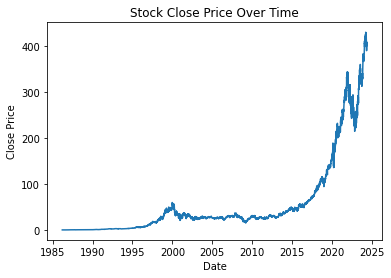

In [ ]:
import matplotlib.pyplot as plt
pandas_df = df.toPandas()

# Plot 'Close' column using Matplotlib
plt.plot(pandas_df['Date'], pandas_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time')
plt.show()


### ML Model Building

In [ ]:
# Define assembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Apply assembler to create features column
df = assembler.transform(df)

# Split data into train, validation, and test sets
train_df, val_df, test_df = df.randomSplit([0.8, 0.1, 0.1], seed=42)

### 1. Random Forest Regression

In [ ]:
# Train Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Close", seed=42)
rf_model = rf.fit(train_df)

# Make predictions on validation set
val_predictions = rf_model.transform(val_df)

In [ ]:
# Evaluate model performance on validation set
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(val_predictions)
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse}")

Root Mean Squared Error (RMSE) on validation data: 8.668865263089016


In [ ]:
# Make predictions on test set
rf_test_predictions = rf_model.transform(test_df)

In [ ]:
# Evaluate model performance on test set
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rf_rmse}")

Root Mean Squared Error (RMSE) on test data: 8.432635835838122


In [ ]:
# Compute other metrics: Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(rf_test_predictions)
    print(f"{metric.upper()}: {value}")

MAE: 3.8424694657278446
R2: 0.9884220038341154


In [ ]:
# Assuming you want to predict stock price on a specific date
specific_date = "2024-05-03"
specific_data = df.filter(col("Date") == specific_date)

# Make predictions on the specific date
specific_predictions = rf_model.transform(specific_data)

# Display the predictions
specific_predictions.select("Date", "Close", "prediction").show()

+----------+----------+------------------+
|      Date|     Close|        prediction|
+----------+----------+------------------+
|2024-05-03|406.660004|360.07100200201234|
+----------+----------+------------------+



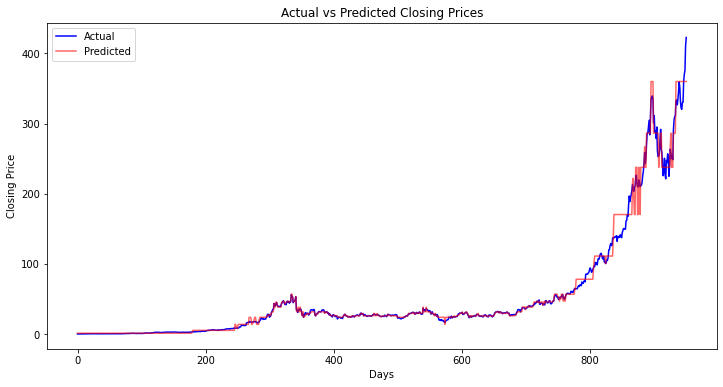

In [ ]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = rf_test_predictions.select("Close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### 2. Gradient Boost Regression

In [ ]:
#Applying Gradient booster 
from pyspark.ml.regression import GBTRegressor

# Train Gradient Boosted Trees model
gbt = GBTRegressor(featuresCol="features", labelCol="Close")
gbt_model = gbt.fit(train_df)

In [ ]:
# Make predictions on test set
gbt_test_predictions = gbt_model.transform(test_df)

In [ ]:
# Evaluate model performance on test set
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
gbt_rmse = evaluator.evaluate(gbt_test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {gbt_rmse}")

Root Mean Squared Error (RMSE) on test data: 8.366385217850503


### 3. Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

# Train Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Close")
lr_model = lr.fit(train_df)

In [ ]:
lr_test_predictions = lr_model.transform(test_df)

In [ ]:
# Evaluate model performance on test set
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {lr_rmse}")


Root Mean Squared Error (RMSE) on test data: 1.7040430331486127


### Comparion between models RMSE value 

In [ ]:
print(f"Linear Regression: {lr_rmse}")
print(f"Random Forest: {rf_rmse}")
print(f"Gradient Boosted trees: {gbt_rmse}")

Linear Regression: 1.7040430331486127
Random Forest: 8.432635835838122
Gradient Boosted trees: 8.366385217850503


### SARAMI Model 

In [ ]:
import statsmodels.api as sm

In [ ]:
# Fit Seasonal ARIMA model
# Specify order and seasonal_order parameters based on data analysis
order = (2, 1, 2)  # Example order parameters
seasonal_order = (1, 1, 1, 12)  # Example seasonal_order parameters
model = sm.tsa.SARIMAX(pandas_df['Close'], order=order, seasonal_order=seasonal_order)
arima_model = model.fit()

# Make predictions on validation set
val_predictions = arima_model.forecast(steps=len(val_df.collect()))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Make predictions on test set
test_predictions = sarima_model.forecast(steps=len(test_df.collect()))

# Convert test predictions to Pandas DataFrame
test_predictions_df = pd.DataFrame(test_predictions, columns=['Predicted_Close'])

# Extract actual closing prices from the test DataFrame
actual_close = test_df.select('Close').collect()

# Calculate RMSE for test data
test_rmse = np.sqrt(mean_squared_error(actual_close, test_predictions))

# Print RMSE for test data
print("Root Mean Squared Error (RMSE) on test data:", test_rmse)

Root Mean Squared Error (RMSE) on test data: 401.81806764849665
